# Observing surface water extent from space <img src="../fig/itc-logo@2x.png" alt="drawing" align = "right" width="50"/>


<b>Author</b>: [Amin Shakya](https://github.com/mn5hk), February, 2024

<b>Github link to the exercise files (base repository)</b>: https://github.com/ITC-Water-Resources/itc-hydrafloods-2024

<b>Credits</b>:

- [Mickey Maganini](https://github.com/mickymags) - slight updates to the course notebooks originally developed by Micky for the ITC course in 2023    
- [Kel Markert](https://github.com/KMarkert) - [troubleshoot](https://github.com/Servir-Mekong/hydra-floods/issues/48) for Landsat 8 data update on Google Earth Engine Data Catalog
- [Roelof Rietbroek](https://github.com/strawpants) - for his consultation on developing the tutorials

---

# Goal of the Study

<div class="alert alert-block alert-info">
In this notebook, we apply the same ideas (as the Tonle Sap, Indonesia case) to a different case study for the flooding in Somalia in 2023. The students are strongly encouraged to play around with the module and to implement it in their case studies of choice.
</div>

<div class="alert alert-block alert-info">


In this notebook, we will implement the techniques learn in the Tonle Sap, Indonesia case study, and apply it to analyze the case study of Somalia flood 2023.

</div>

## Context

Huge flood in Somalia in 2023. Here we focus on the town of Beledweyne [[source](https://reliefweb.int/report/somalia/somali-city-beledweyne-85-under-water-following-devastating-floods)].

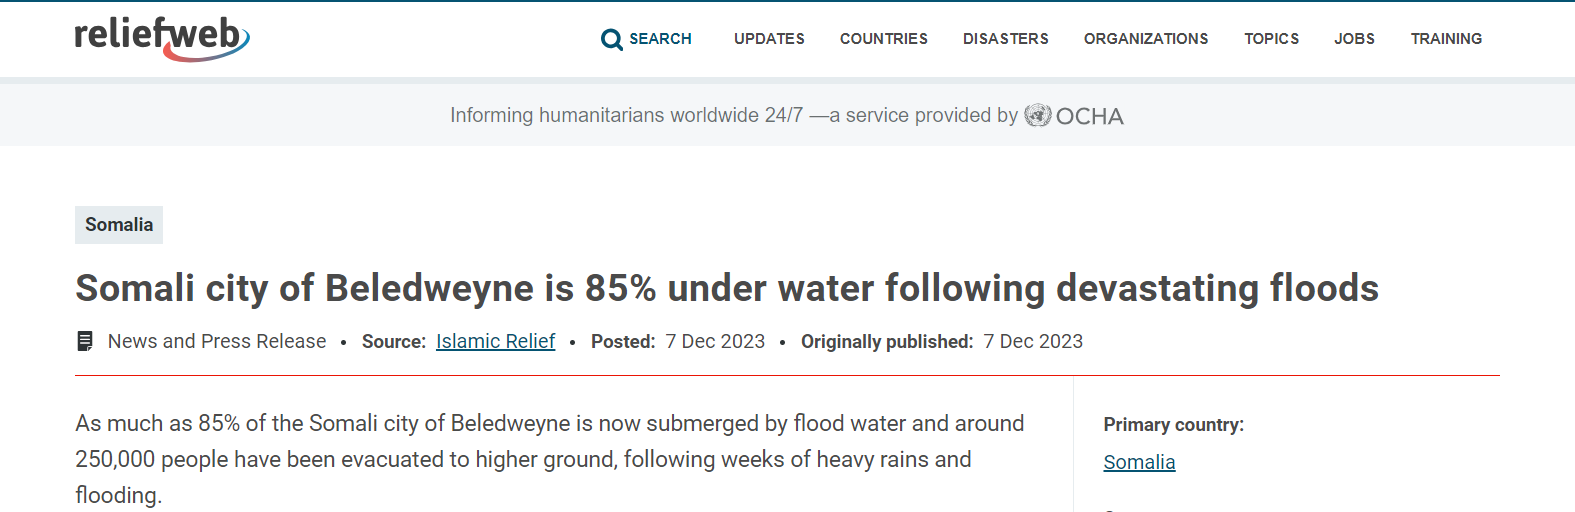

<div class="alert alert-block alert-warning">
    <b>Caution:</b> ⚠️ This notebook has been developed strictly for the purpose of this course, and the results have not been validated on the ground.
</div>


<a id="01"></a>
___
## 01. Import Python libraries and initialize Google Earth Engine

### 01a. Install python libraries

In [1]:
# !pip install ee
# !pip install hydrafloods
# !pip install geemap

### 01b. Import Python libraries

In [2]:
import geemap
import geemap.colormaps as cm
import ee
import hydrafloods as hf
from hydrafloods import corrections

### 01c. Initialize [geemap](https://github.com/gee-community/geemap), and check [hydrafloods](https://github.com/Servir-Mekong/hydra-floods) version

In [1]:
ee.Authenticate()
ee.Initialize()

In [4]:
_ = geemap.Map()

In [5]:
hf.__version__

'2023.10.14'

---
## 02. Define region of interest, time period

### 02a. Define study region of interest

In [6]:
# Beledweyne town somalia
somalia_flood = ee.Geometry.Polygon([
        [44.85, 4],
        [45.85, 4],
        [45.85, 5],
        [44.85, 5]
    ])

# kakhovka_dam = ee.Geometry.Polygon([
#         [46, 33],
#         [46, 34],
#         [47, 34],
#         [47, 33]
#     ])

### 02b. Define start and end time

In [7]:
#Define time period of interest
start_date = "2023-11-15"
end_date = "2023-12-15"

---
# Working with Earth Observation data

## 03. Optical Imagery Workflow

### 03a. Acquire optical data using hf.dataset

In [8]:
#Acquire optical data using hf.dataset
optical = hf.Landsat8(somalia_flood, start_date, end_date)

##### Apply a function to rename some parameters

In [9]:
# function to rename the sun angle properties to what is expected by
# the illumination_correction function
def rename_sunangle_properties(image):
    sz = ee.Number(90).subtract(image.get('SUN_ELEVATION'))
    sa = image.get('SUN_AZIMUTH')
    return image.set({"SOLAR_ZENITH_ANGLE": sz, "SOLAR_AZIMUTH_ANGLE": sa})

# apply the function to rename properties
optical = optical.apply_func(rename_sunangle_properties)

### 03b. Apply illumination correction

##### Acquire DEM data

Please note that users have a choice of DEM in this step.

In [10]:
# https://www.youtube.com/watch?v=uCzNxG4Q9aI
elv = ee.Image("JAXA/ALOS/AW3D30/V2_2").select("AVE_DSM").unmask(0) #JAXA ALOS DEM
# merit_dem = ee.Image("MERIT/Hydro/v1_0_1").select("elv").unmask(0) #Merit-Hydro DEM: A hydrologically-adjusted DEM from Yamakazi, D. et al. 2019

In [11]:
opt_corrected = optical.apply_func(hf.corrections.illumination_correction, elevation = elv, scale=180) #Use JAXA DEM
# opt_corrected = optical.apply_func(hf.corrections.illumination_correction, elevation = dem, scale=180) #Use MERIT-Hydro DEM

### 03c. Apply a reducer

In [12]:
opt_reduced = opt_corrected.collection.median()
# opt_reduced = opt_corrected.collection.mean()
# opt_reduced = opt_corrected.collection.mosaic()
# opt_reduced = opt_corrected.collection.first()
# opt_reduced = opt_corrected.collection.last()

### 03d Thresholding

In [13]:
#Optical thresholding

mndwi = opt_corrected.apply_func(hf.add_indices, indices = ["mndwi"])

mndwi_reduced = mndwi.collection.median()

opt_water = hf.edge_otsu(
    mndwi_reduced,
    "mndwi",
    initial_threshold = 0,
    thresh_no_data = 0.5,
    edge_buffer = 300,
    scale = 1e3,
    invert = True,
    region = somalia_flood
)

### 03d* Visualization

In [14]:
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

Map = geemap.Map(center = (5, 46.5), zoom = 9)

Map.addLayer(somalia_flood, {}, 'Beledweyne, Somalia')
Map.addLayer(opt_water.selfMask(), water_params, 'Maximum Flood Water in Beledweyne, Somalia 2023 (using Optical imagery)')

Map.addLayerControl()
Map

Map(center=[5, 46.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

## 04. Flood Analysis using SAR imagery

### 04a. Acquire optical data using hf.dataset

In [15]:
sar = hf.Sentinel1(somalia_flood, start_date, end_date)

### 04b. Apply some corrections (Speckle filter)

In [16]:
sar_speckle_filt = sar.apply_func(hf.gamma_map)
sar_corrected = sar_speckle_filt.apply_func(corrections.slope_correction, elevation = elv, buffer = 30)

### 04c. Apply a reducer

In [17]:
sar_reduced = sar_corrected.collection.max()

### 04d Thresholding

In [18]:
sar_water = hf.edge_otsu(
    sar_reduced,
    "VV",
    initial_threshold = -11, # Play around with the threshold values a bit?
    thresh_no_data = -20,
    edge_buffer = 300,
    region = somalia_flood,
    scale = 1e3)

### 04d* Visualization

In [19]:
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

Map = geemap.Map(center = (5, 46.5), zoom = 9)

Map.addLayer(somalia_flood, {}, 'Beledweyne, Somalia')
# Map.addLayer(opt_water, water_params, 'Optical-detected Water')
# Map.addLayer(sar_water.selfMask(), water_params, 'Flood Water 2023')
Map.addLayer(sar_water.selfMask(), water_params, 'Maximum Flood Water in Beledweyne, Somalia 2023 (using SAR imagery)')
Map.addLayerControl()
Map

Map(center=[5, 46.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

## 05 Compare visualization: Optical vs SAR

In [20]:
water_params_lightblue = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '0000FF']
}

water_params_darkblue = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

#https://geemap.org/notebooks/04_split_panel_map/
left_layer = geemap.ee_tile_layer(opt_water.selfMask(), water_params_lightblue, 'Maximum Flood Water in Beledweyne, Somalia 2023 (using Optical imagery)')
right_layer = geemap.ee_tile_layer(sar_water.selfMask(), water_params_darkblue, 'SAR-detected Water')

Map = geemap.Map(center = (5, 46.5), zoom = 9)
Map.split_map(left_layer, right_layer)
Map.addLayer(somalia_flood, {}, 'Region of Interest')
Map

Map(center=[5, 46.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

<div class="alert alert-block alert-info">
    <b>Discussion:</b> ❓ In this case study, optical seems to show more flood water, why? 
    <br>Date of image acquisition? Choice of reducer/indices/threshold? Any other reason?
</div>


<div class="alert alert-block alert-warning">
    <b>Caution:</b> ⚠️ Some ground data often important to validate our earth observation results.
</div>


---

<div class="alert alert-block alert-info">
    <b>Discussion:</b> ❓ Before the flood in Somalia of December, 2023, there was a three-year long big drought. Can we use the skills we learn today to compare the water extent between the two conditions? What applications may surface water mapping have in this case?
</div>


## 06 Assignment (Optional)

> Compute water extent in the same region during the drought.

In [21]:
pre_start_date = "2022-11-15"
pre_end_date = "2022-12-15"

#Acquire Sentinel 1 data from hydrafloods for the "somalia_flood" region of interest, for the time period [pre_start_date] to [post_start_date]
preevent = hf.Sentinel1( ?, ?, ?)

#Apply slope correction on the Sentinel 1 image collection
preevent_flat = preevent.apply_func(hf.slope_correction, elevation = ?, buffer = 100)

#Apply speckle filter on the slope-corrected image 
preevent_filtered = ?.apply(hf.gamma_map)

Take a reducer to get an image
pre_img = ?.collection.median()

# Thresholding: Apply Edge-Otsu method
pre_water = hf.edge_otsu(
    ?,
    "VV",
    initial_threshold = -18,
    thresh_no_data = -25,
    edge_buffer = 300,
    region = ?,
    scale = 1e3)

#The difference between two images can be calculated using the discrete difference method in hydrafloods
flood_diff = hf.floods.discrete_difference(sar_water, pre_water) 

SyntaxError: invalid syntax (1487594133.py, line 5)

In [ ]:
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

pre_water_params = {
    "min": 0,
    "max": 1,
    "palette": "lightblue"
}

diff_water_params = {
    "min": 0,
    "max": 1,
    "palette": "red"
}

#https://geemap.org/notebooks/04_split_panel_map/
left_layer = geemap.ee_tile_layer(sar_water.selfMask(), water_params, 'SAR-detected Water')
right_layer = geemap.ee_tile_layer(pre_water.selfMask(), water_params, 'Pre-flood Water')

Map = geemap.Map(center = (5, 46.5), zoom = 9)
Map.split_map(left_layer, right_layer)
Map.addLayer(somalia_flood, {}, 'Region of Interest')
Map

## 07. Answer provided below!

In [22]:
pre_start_date = "2021-11-15"
pre_end_date = "2021-12-15"
preevent = hf.Sentinel1(somalia_flood, pre_start_date, pre_end_date)
preevent_flat = preevent.apply_func(hf.slope_correction, elevation = elv, buffer = 100)
preevent_filtered = preevent_flat.apply(hf.gamma_map)
pre_img = preevent_filtered.collection.mean()
# pre_water = hf.edge_otsu(pre_img, bands = "VV", initial_threshold = 16, edge_buffer = 300, region = tonlesap, scale = 300)

pre_water = hf.edge_otsu(
    pre_img,
    "VV",
    initial_threshold = -18,
    thresh_no_data = -25,
    edge_buffer = 300,
    region = somalia_flood,
    scale = 1e3)

flood_diff = hf.floods.discrete_difference(sar_water, pre_water) 

In [23]:
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

pre_water_params = {
    "min": 0,
    "max": 1,
    "palette": "lightblue"
}

diff_water_params = {
    "min": 0,
    "max": 1,
    "palette": "red"
}

# Map.addLayer(somalia_flood, {}, 'Region of Interest')
# # Map.addLayer(opt_water, water_params, 'Optical-detected Water')
# Map.addLayer(sar_water.selfMask(), water_params, 'SAR-detected flood Water')
# # Map.addLayer(pre_water.selfMask(), pre_water_params, 'Pre Flood Water')
# Map.addLayer(flood_diff.selfMask(), diff_water_params, 'Excess Water Extent (Compared to Drought in 2022)')
# Map.addLayerControl()
# Map

In [24]:
#https://geemap.org/notebooks/04_split_panel_map/
left_layer = geemap.ee_tile_layer(sar_water.selfMask(), water_params, 'SAR-detected Water')
right_layer = geemap.ee_tile_layer(pre_water.selfMask(), water_params, 'Pre-flood Water')

Map = geemap.Map(center = (5, 46.5), zoom = 9)
Map.split_map(left_layer, right_layer)
Map.addLayer(somalia_flood, {}, 'Region of Interest')
Map

Map(center=[5, 46.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

<div class="alert alert-block alert-info">
    <b>Take home messages:</b> 
    <ul>
        <li>Earth observation datasets are a useful tool to detect surface water extent</li>
        <li>Multiple choices of EO datasets --> e.g., Optical vs SAR</li>
        <li>Multiple choice of methods to derive surface water extent --> Important to distinguish pros and cons</li>
        <li>Ground data often important to validate our EO-based results</li>
        <li>A relevant recent paper by Adnan et al., (2024): <a href = "https://iopscience.iop.org/article/10.1088/1748-9326/ad1722">A call for consistency and integration in global surface water estimates</a></li>
    </ul>
</div>
